In [3]:
import sys
import json
import pandas as pd

## Filter structures

In [4]:
import sys

from apo_holo_structure_stats.pipeline.utils.json import read_jsons_with_seqs

filtered__json_folder = '/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/meta_output/filtered.json_shard.d/*'
df = read_jsons_with_seqs(filtered__json_folder)
df = df.drop(columns='sequence')


loading filtered.json_shard24: 100/100
concatenating...
done.


In [5]:
df.describe(include='all')


,uniprotkb_id,pdb_code,uniprot_group_size,path,chain_id,is_holo
count,275659,275659,275659.000000,275659,275659,275659
unique,31511,119076,NaN,125155,2036,2
top,Q79791,3j3q,NaN,../input/pdb_structs88/3j3q.cif.gz,A,True
freq,2582,1356,NaN,1356,114944,171911
mean,NaN,NaN,142.688535,NaN,NaN,NaN
std,NaN,NaN,338.779873,NaN,NaN,NaN
min,NaN,NaN,2.000000,NaN,NaN,NaN
25%,NaN,NaN,8.000000,NaN,NaN,NaN
50%,NaN,NaN,26.000000,NaN,NaN,NaN
75%,NaN,NaN,107.000000,NaN,NaN,NaN


Compute upper bound of count of a-h pairs (for each uniprot group)

In [6]:
by_unp = df.groupby('uniprotkb_id')
holos_by_group = by_unp['is_holo'].sum()
apos_by_group = by_unp['is_holo'].count() - holos_by_group

ub_pairs_by_group = (apos_by_group * holos_by_group).rename('upper_bound_on_pairs')
print('ub on all pairs:', ub_pairs_by_group.sum())
ub_pairs_by_group.describe()


ub on all pairs: 2973238


count     31511.000000
mean         94.355558
std        3287.218990
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max      395527.000000
Name: upper_bound_on_pairs, dtype: float64

clip: 10 ub_pairs: 61109 ecdf:  0.8654
clip: 100 ub_pairs: 228713 ecdf:  0.9653
clip: 1000 ub_pairs: 616695 ecdf:  0.9929
clip: inf ub_pairs: 2973238 ecdf:  0.0000


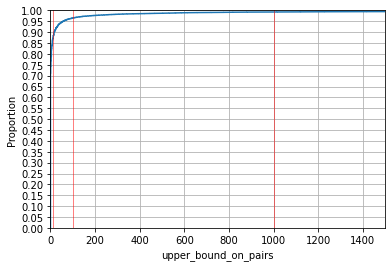

In [7]:
from matplotlib import pyplot as plt, ticker
import numpy as np
import seaborn as sns

ax = sns.ecdfplot(ub_pairs_by_group)
ax.set(xlim=(0, 1500))
plt.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

upper_clip = [10, 100, 1000, np.inf]

def find_nearest_idx(array, value):
    return (np.abs(array - value)).argmin()

ecdf_y, ecdf_x = np.sort(ub_pairs_by_group.to_numpy()), np.linspace(0, 1, len(ub_pairs_by_group), endpoint=False)


for clip in upper_clip:
    ax.axvline(clip, c='r', lw=0.5)
    ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
    print('clip:', clip, 'ub_pairs:', ub_pairs_by_group.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')

plt.show()


## Make Pairs LCS

In [4]:
import pandas as pd
import json
#
# potential_pairs = pd.read_json('/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_make_pairs_lcs', )
# print(len(potential_pairs))
#


In [5]:
json_filename = '/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_make_pairs_lcs'
with open(json_filename) as f:
    potential_pairs = pd.json_normalize(json.load(f))


In [10]:
potential_pairs.describe()

,lcs_result.length,lcs_result.i1,lcs_result.i2,lcs_result.mismatches,lcs_result.leading_mismatches,lcs_result.trailing_mismatches
count,2.973238e+06,2.973238e+06,2.973238e+06,2.973238e+06,2.973238e+06,2.973238e+06
mean,1.622273e+02,4.757007e+01,5.342030e+01,8.702955e+01,3.326011e+01,5.376944e+01
std,1.546087e+02,1.131088e+02,1.137240e+02,1.633831e+02,8.893563e+01,1.259912e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.270000e+02,2.000000e+00,2.000000e+00,3.500000e+01,0.000000e+00,0.000000e+00
75%,2.210000e+02,4.700000e+01,6.900000e+01,1.030000e+02,3.300000e+01,5.900000e+01
max,4.620000e+03,2.843000e+03,4.221000e+03,2.083000e+03,2.083000e+03,1.618000e+03


In [6]:
print(len(potential_pairs))
pairs = potential_pairs[potential_pairs['lcs_result.mismatches'] == 0]
print(len(pairs))

2973238
1132444


In [15]:
len(pairs[pairs['lcs_result.length'] < 50])
# todo I can remove those from results
# and the shortest give errors in run_analyses (if all are unobserved - 0 residues), but that's ok..

1258

In [12]:
pairs.describe()

,lcs_result.length,lcs_result.i1,lcs_result.i2,lcs_result.mismatches,lcs_result.leading_mismatches,lcs_result.trailing_mismatches
count,1.132444e+06,1.132444e+06,1.132444e+06,1132444.0,1132444.0,1132444.0
mean,2.191686e+02,3.523263e+00,6.990543e+00,0.0,0.0,0.0
std,1.394397e+02,2.338920e+01,3.943674e+01,0.0,0.0,0.0
min,3.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0
25%,1.290000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
50%,1.690000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
75%,3.060000e+02,0.000000e+00,0.000000e+00,0.0,0.0,0.0
max,4.620000e+03,2.327000e+03,2.987000e+03,0.0,0.0,0.0


In [13]:
# todo join with unp ids and find out the distribution in groups.
# if same as potential pairs or not.
chains = pd.read_json('/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_groups.json')
pairs = pairs.merge(chains.set_index(['pdb_code', 'chain_id']), left_on=['pdb_code_apo', 'chain_id_apo'], right_index=True)

In [14]:
pairs.columns

Index(['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo',
       'lcs_result.length', 'lcs_result.i1', 'lcs_result.i2',
       'lcs_result.mismatches', 'lcs_result.leading_mismatches',
       'lcs_result.trailing_mismatches', 'uniprotkb_id', 'uniprot_group_size'],
      dtype='object')

In [15]:
pairs_per_group = pairs.groupby('uniprotkb_id').size()
pairs_per_group.describe()

count      6893.000000
mean        164.521399
std        3239.701243
min           1.000000
25%           2.000000
50%           6.000000
75%          18.000000
max      167995.000000
dtype: float64

Z hlediska cachování modelů by mě zajímalo, kolikrát maximálně (a průměrně) v párech figuruje jedna struktura. (A všechno jsou ekvivalence/je to tranzitivní? Nutně nemusí, jde-li o jiné úseky třeba, ale většinou jo, je-li tam nějaký překryv, je to implikováno, ale? - počítám a1, a2 k h1 a pak vezmeš h2, která je na a1, je taky k a2? Za předpokladu, že mají LCS(a1, h1) a LCS(a1, h2) nějaký překryv.

No každopádně -- udělej groupby struktura sizes... (ani nemusíš myslim podle uniprotu)

Dalo by se to dělat takto
- načíst vždy 5 apo a k nim vystridat 5 holo, dalsich 5 holo,...
    - 25 párů a pouze 5 načítání -> 5x reduction in parsing structures time

A když jsme u zrychlování - nemusím načítat nebo aspoň držet v paměti celou strukturu, když mi stačí chain (nebo ty set_of_residues)
- samozřejmě biopython má reference i nahoru, takže bych ten chain musel disconnectnout, pokud chci pracovat s residues objekty (a ne treba jenom c alpha coords)
    - na to c alpha coords bych si mohl koneckonců napsat parser sám,... ale to už ne (potřebuju všechny atomy, pro interface, ne jen calpha..)
    - no ale dalo by se to udelat megaefektivne - jenom coords v numpy a treba indices AAs/ atom typy
    - asi musim prijmout, ze to neni efektivni a pouzivam to...
    - kazdopadne, chain bych disconnectnout mohl?

In [16]:
from typing import List


def total_when_clipped(upper_clips: List[float], group_counts, ax=None, color='r', label='counts'):

    def find_nearest_idx(array, value):
        return (np.abs(array - value)).argmin()

    ecdf_y, ecdf_x = np.sort(group_counts.to_numpy()), np.linspace(0, 1, len(group_counts), endpoint=False)

    for clip in upper_clips:
        if ax:
            ax.axvline(clip, c=color, lw=0.5)
        ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
        print('clip:', clip, f'{label}:', group_counts.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')



# apo
count    36452.000000
mean        31.110666
std         66.606124
min          1.000000
25%          2.000000
50%          6.000000
75%         22.000000
max        613.000000
dtype: float64
clip: 5 total pairs cached: 133423 ecdf:  0.4595
clip: 10 total pairs cached: 213401 ecdf:  0.6136
clip: 50 total pairs cached: 539586 ecdf:  0.8423
clip: inf total pairs cached: 1134046 ecdf:  0.0000
# holo
count    58464.000000
mean        19.397339
std         73.000867
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max        749.000000
dtype: float64
clip: 5 total pairs cached: 193817 ecdf:  0.5793
clip: 10 total pairs cached: 284642 ecdf:  0.7518
clip: 50 total pairs cached: 567494 ecdf:  0.9239
clip: inf total pairs cached: 1134046 ecdf:  0.0000


Text(0.5, 1.0, '# pairs per structure')

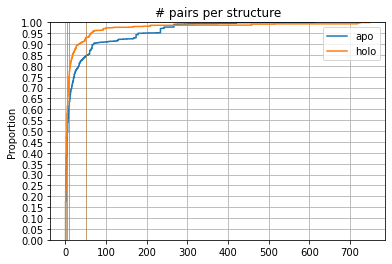

In [17]:
colors = iter(sns.color_palette())
for a_or_h in ('apo', 'holo'):
    print('#', a_or_h)
    pairs_per_apo = pairs.groupby([f'pdb_code_{a_or_h}', f'chain_id_{a_or_h}']).size()
    print(pairs_per_apo.describe())
    ax = sns.ecdfplot(pairs_per_apo, label=a_or_h)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

    total_when_clipped([5, 10, 50, np.inf], pairs_per_apo, ax=ax, color=next(colors), label='total pairs cached')
plt.grid()
ax.legend()
plt.title('# pairs per structure')



count    36452.000000
mean        31.110666
std         66.606124
min          1.000000
25%          2.000000
50%          6.000000
75%         22.000000
max        613.000000
dtype: float64


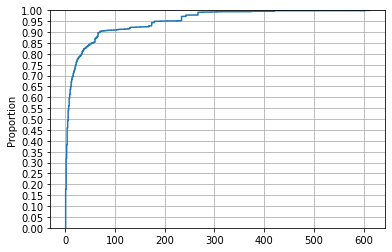

In [18]:
pairs_per_apo = pairs.groupby(['pdb_code_apo', 'chain_id_apo']).size()
print(pairs_per_apo.describe())
ax = sns.ecdfplot(pairs_per_apo)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plt.grid()

clip: 10 pairs: 41116 ecdf:  0.6308
clip: 100 pairs: 131669 ecdf:  0.9198
clip: 200 pairs: 174086 ecdf:  0.9514
clip: 1700 pairs: 356659 ecdf:  0.9903
clip: inf pairs: 1134046 ecdf:  0.0000


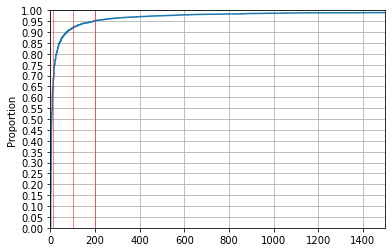

In [19]:

from matplotlib import pyplot as plt, ticker
import numpy as np
import seaborn as sns

ax = sns.ecdfplot(pairs_per_group)
ax.set(xlim=(0, 1500))
plt.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

upper_clip = [10, 100, 200, 1700, np.inf]

def find_nearest_idx(array, value):
    return (np.abs(array - value)).argmin()

ecdf_y, ecdf_x = np.sort(pairs_per_group.to_numpy()), np.linspace(0, 1, len(pairs_per_group), endpoint=False)


for clip in upper_clip:
    ax.axvline(clip, c='r', lw=0.5)
    ecdf_val = ecdf_x[find_nearest_idx(ecdf_y, clip)]
    print('clip:', clip, 'pairs:', pairs_per_group.clip(upper=clip).sum(), 'ecdf: ', f'{ecdf_val:.4f}')


[(0.0, 30.0)]

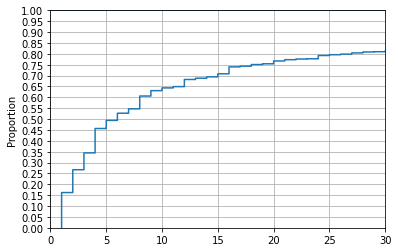

In [20]:
# musel jsem to zkopirovat, nevim, jak to zobrazit znova s jinym xlim
ax = sns.ecdfplot(pairs_per_group)
plt.axhline(np.max(ax.lines[0].get_ydata()))
plt.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set(xlim=(0, 30))

## Run analyses

In [1]:

# import matplotlib as mpl
# # do prdele, rozbiji to tohle? Proc tu nejsou grafy? Mozna nejdriv importovat seaborn? Nebo restartovat počítač?
# # mpl.rcdefaults()  # for some reason makes charts ~2x bigger (but values before and after are only by 20% larger...)
#
# mpl.rc('figure', dpi=150)

TODO
- mozna filtrovat na lcs len >= 50 (par jich je nesmyslnejch)
- zobrazit si jenom 1 zastupce z uniprot skupiny (ale to clusterovani jako oni je asi lepsi)
  - jenom join s chainy (nahore join s makepairslcs, to se ale nevejde uz do ramky, ne?, mozna ze jenom len vejde, ale musel bych ho vyzobnout v json.load
  - clusterovani
    - mozna by stacilo si stahnout to uniref nebo co, kde jsou podle thresholdu! A nemusel bych to delat
     vubec sam (i kdyz tam 1 nevyhoda tech neprekryvů ale stejny uniprot - jina cast proste, dokonce to meli i oni asi 4? takovy reprezentanty, no, z 500.. tak asi nic xtra dulezityho)
- pokud neudelam clusterovani, mozna by to chtelo neco jinyho nez tyhle tecky.. bud krizky nebo heat/hue

Proc se nektery grafy lisi of paperu/naší replikace
- raw-všechny páry nejsou clusterovaný ani vyvážený v rámci uniprot skupiny, takže ty velký převážej a ty percentage grafy pak vypadaj jinak (např ss identity má mnohem vyšší část u 0.98-1, protože se zrovna v početný unp skupině nemění moc ss (asi))
- jinak vypadaj hlavne percentage grafy


Load input files (outputs from `run_analyses`):

In [2]:
from apo_holo_structure_stats.pipeline.utils.json import read_jsons_to_df
from apo_holo_structure_stats.results.json_deserialize import tuple_it, unfold_tuple_to_columns, tuple_columns

import itertools
from pathlib import Path

import pandas as pd

# import importlib
# import apo_holo_structure_stats
# importlib.reload(apo_holo_structure_stats.pipeline.utils.json)


OUTPUT_PATH = '/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/ignore/run_analyses_fixed/output'
OUTPUT_PATH = Path(OUTPUT_PATH)

analyses_jsons = OUTPUT_PATH.rglob('output_apo_holo*')
domains_jsons = OUTPUT_PATH.rglob('output_domains*')

# for testing
# analyses_jsons = itertools.islice(analyses_jsons, 100)
# domains_jsons = itertools.islice(domains_jsons, 100)

analyses_df = read_jsons_to_df(analyses_jsons)
domain_info = read_jsons_to_df(domains_jsons)
domain_info = domain_info.applymap(tuple_it)

print(len(analyses_df))
print(len(domain_info))

loading output_apo_holo_2021-12-30T18:05:23.943783.json: 400/400
concatenating...
done.
loading output_domains_info_2021-12-30T18:05:23.943783.json: 400/400
concatenating...
done.
4989332
3991017


Proč ~je~ bylo filů jen 385?
- u 7 jobů se nenainstaloval package (pip seaborn, pandas), WTF?
- co ty zbylé? těch 8?

celkem 15 jsem nasel pomocí  `grep -e 'ERROR:[^a][^p]' run_analyses_fixed/job_script*`
takže všechny

vyřešil jsem to zatim pomocí metacentrum_scripts/submit_failed_run_analyses.py
- prostě spustím job znova..

Nevim, co to zpusobuje, mozna by to vyresil vetsi timeout v pipu?
Nektery chyby vypadaj zpusobeny 2 pipama, ale vzdy pouzivam `pip`, i u jeho upgradu, tak nevim, kde by mohl nastat rozdil
    - protoze pip se tam uspesne upgraduje, a pak to pise, ze se upgradovat výš z té původní, na tu, kde přece teďka nově je ... wtf..

Nevim, jestli je problem třeba jen na některých comp. nodech, zkusil jsem jeden (kde byla jedna z tech chyb) a normalně to fungovalo, takze ne nutně.

https://stackoverflow.com/questions/59702111/intermittent-pip-install-error-in-virtualenv
https://stackoverflow.com/questions/53661293/why-is-pip-asking-me-to-upgrade-when-its-already-up-to-date

DH:
už se mu to stalo, asi má pypi nějaký limity na IP adresu, šlo by vyřešit proxy serverem, který by si ty balíčky cachoval, aby se ty stejné (architektury) nestahovaly z pypi znovu


````
run_analyses_fixed/job_script043.sh.e9899023:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script043.sh.e9899023:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script043.sh.e9899023:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899023.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script052.sh.e9899030:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899030.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script060.sh.e9899361:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899361.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script061.sh.e9899332:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script061.sh.e9899332:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script061.sh.e9899332:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899332.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script097.sh.e9899018:  ERROR: Could not find a version that satisfies the requirement seaborn==0.11.2 (from -r requirements.txt (line 8)) (from versions: none)
run_analyses_fixed/job_script097.sh.e9899018:ERROR: No matching distribution found for seaborn==0.11.2 (from -r requirements.txt (line 8))
run_analyses_fixed/job_script097.sh.e9899018:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899018.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script146.sh.e9899358:ERROR: Could not find a version that satisfies the requirement pandas==1.3.4 (from versions: none)
run_analyses_fixed/job_script146.sh.e9899358:ERROR: No matching distribution found for pandas==1.3.4
run_analyses_fixed/job_script167.sh.e9899357:ERROR: Could not find a version that satisfies the requirement pandas==1.3.4 (from versions: none)
run_analyses_fixed/job_script167.sh.e9899357:ERROR: No matching distribution found for pandas==1.3.4
run_analyses_fixed/job_script270.sh.e9899090:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899090.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script277.sh.e9899296:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899296.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script308.sh.e9899012:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899012.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script328.sh.e9899011:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899011.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script342.sh.e9899027:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899027.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script379.sh.e9899326:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script379.sh.e9899326:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script379.sh.e9899326:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899326.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats
run_analyses_fixed/job_script393.sh.e9899301:  ERROR: Could not find a version that satisfies the requirement pip (from versions: none)
run_analyses_fixed/job_script393.sh.e9899301:ERROR: No matching distribution found for pip
run_analyses_fixed/job_script393.sh.e9899301:ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /scratch/baobab/job_9899301.meta-pbs.metacentrum.cz/apo-holo-protein-structure-stats


````

Chyba `File "setup.py" not found. Directory cannot be installed in editable` znamená, že se neaktualizoval pip

In [3]:
from collections import defaultdict

analyses_by_level = defaultdict(list)

for obj in analyses_df.itertuples():
    obj = obj._asdict()
    obj['args'] = tuple_it(obj['args'])  # json converted all my tuples to lists... won't work with hashing for joins..
    analyses_by_level[obj['level_tag']].append(obj)

# todo possibly del analyses_df

# convert analyses outputs to DataFrames
for k in analyses_by_level:
    analyses_by_level[k] = pd.DataFrame(analyses_by_level[k])


In [4]:
analyses_by_level

defaultdict(list,
            {'chain2chain':          Index              analysis_name                    args kwargs  \
             0            0                    GetRMSD  ((7kqo, B), (5s4b, A))     {}   
             1            1  CompareSecondaryStructure  ((7kqo, B), (5s4b, A))     {}   
             2            2                    GetRMSD  ((7kqo, B), (5s4c, A))     {}   
             3            3  CompareSecondaryStructure  ((7kqo, B), (5s4c, A))     {}   
             4            4                    GetRMSD  ((7kqo, B), (5s4a, B))     {}   
             ...        ...                        ...                     ...    ...   
             2003076  10531  CompareSecondaryStructure  ((2chs, J), (1dbf, A))     {}   
             2003077  10534                    GetRMSD  ((2chs, J), (1dbf, B))     {}   
             2003078  10535  CompareSecondaryStructure  ((2chs, J), (1dbf, B))     {}   
             2003079  10538                    GetRMSD  ((2chs, J), (1dbf, C)

In [6]:
import math
import matplotlib
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


import importlib
import apo_holo_structure_stats
from apo_holo_structure_stats.results.json_deserialize import unfold_tuple_to_columns

In [7]:
from pathlib import Path

# sns.reset_orig()
sns.set_context('talk')
matplotlib.rcParams['figure.figsize'] = 8,6

plot_counter = 0
plot_path = Path('output_plots')
plot_path.mkdir(exist_ok=True)

def save_plot():
    global plot_counter
    plt.savefig(str(plot_path / f'paper_plot{plot_counter}.png'))
    plot_counter += 1

In [8]:
# keep False to exclude chimeric chains (that are included due to a mistake, more info at filter_structures.py:268)
a_h_pairs = analyses_by_level['chain2chain'].drop_duplicates(['analysis_name', 'args'], keep=False)['args'].drop_duplicates()
# unfold the tuple of chains into two columns
a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['apo_chain','holo_chain'])
a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['pdb_code_apo', 'chain_id_apo'], 'apo_chain')


In [9]:
from apo_holo_structure_stats.pipeline.make_pairs_lcs import load_pairs_json, pairs_without_mismatches

pairs_filename = '/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_make_pairs_lcs'
pairs = pairs_without_mismatches(load_pairs_json(pairs_filename))
pairs_with_lengths = pairs[['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo']].assign(
    lcs_len=[lcs_result.length for lcs_result in pairs.lcs_result]
).set_index(['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo'])
# apparently, there are some dupes in o_make_pairs_lcs, could be because there are (are there?) dupes of chains in different uniprot groups in the segments observed file? I thought I removed them??
pairs_with_lengths = pairs_with_lengths[~pairs_with_lengths.index.duplicated()]

a_h_pairs = unfold_tuple_to_columns(a_h_pairs, ['pdb_code_holo', 'chain_id_holo'], 'holo_chain')
a_h_pairs = a_h_pairs.merge(pairs_with_lengths,
                             left_on=['pdb_code_apo', 'chain_id_apo', 'pdb_code_holo', 'chain_id_holo'],
                             right_index=True)

print(len(a_h_pairs))
a_h_pairs = a_h_pairs[a_h_pairs.lcs_len >= 50]
print(len(a_h_pairs))


1007118
1006909


In [10]:
# domain_info = domain_info.rename(columns={'result': 'domain_count'})
# I forgot to not save duplicates in run_analyses for full domains, so remove them
# unfortunately due to analyzed_domains being in the same json, it has some NaN cols, so I need to do .drop_duplicates('full_id')
full_domains = domain_info[domain_info['type'] == 'full_domain'].drop_duplicates('full_id').set_index('full_id', verify_integrity=True)

analyzed_domains = domain_info[domain_info['type'] == 'analyzed_domain']
# because of a mistake in removing chimeric chains (>1 uniprot for the chains), there are some left, remove them (should do it for each analysis here)
# more info at filter_structures.py:268
# there are only 600 of the dupes
# todo might do keep=False, but I don't want to remove in from every analysis, too time consuming
analyzed_domains = analyzed_domains.drop_duplicates(['full_id', 'pair_id']).set_index(['full_id', 'pair_id'], verify_integrity=True)


full_domain_counts = full_domains.groupby(by=['pdb_code', 'chain_id']).size()
# full_domain_counts = full_domains.groupby(by=['pdb_code', 'chain_id']).size()
analyzed_domain_counts = analyzed_domains.groupby(by=['pdb_code', 'chain_id']).size()
print(full_domain_counts)
print('single domain proteins', full_domain_counts[full_domain_counts == 1].count())
print('multi domain proteins', full_domain_counts[full_domain_counts > 1].count())

pdb_code  chain_id
104m      A           1
105m      A           1
11ba      A           1
          B           1
11bg      A           1
                     ..
9rsa      A           1
          B           1
9wga      A           4
          B           4
9xia      A           1
Length: 68647, dtype: int64
single domain proteins 46733
multi domain proteins 21914


In [11]:
full_domains

,type,pdb_code,chain_id,domain_id,spans,pair_id,spans_auth_seq_id
full_id,,,,,,,
"(2qgb, A, 2qgbA00)",full_domain,2qgb,A,2qgbA00,"((11, 125),)",NaN,NaN
"(1u21, B, 1u21B00)",full_domain,1u21,B,1u21B00,"((10, 125),)",NaN,NaN
"(1y1d, B, 1y1dB00)",full_domain,1y1d,B,1y1dB00,"((10, 125),)",NaN,NaN
"(1y1d, A, 1y1dA00)",full_domain,1y1d,A,1y1dA00,"((10, 124),)",NaN,NaN
"(2b15, A, 2b15A00)",full_domain,2b15,A,2b15A00,"((10, 125),)",NaN,NaN
...,...,...,...,...,...,...,...
"(2chs, E, 2chsE00)",full_domain,2chs,E,2chsE00,"((2, 115),)",NaN,NaN
"(2chs, F, 2chsF00)",full_domain,2chs,F,2chsF00,"((2, 115),)",NaN,NaN
"(2chs, G, 2chsG00)",full_domain,2chs,G,2chsG00,"((2, 115),)",NaN,NaN


In [12]:
domain_info['chain'] = list(zip(domain_info.pdb_code, domain_info.chain_id))


multi_domain_chains = full_domain_counts[full_domain_counts > 1]
single_domain_chains = full_domain_counts[full_domain_counts == 1]

print(single_domain_chains.count())
print(multi_domain_chains.count())

print(len(multi_domain_chains))
# print(domain_count)
print(len(single_domain_chains))

# label single, multi domain pairs
a_h_pairs = a_h_pairs.merge(full_domain_counts.rename('domain_count'), left_on=['pdb_code_apo', 'chain_id_apo'],                                                                                            right_index=True)
#
# multi_domain_pairs = a_h_pairs.merge(multi_domain_chains, left_on='apo_chain', right_on='chain')[['apo_chain',
#                                                                                                   'holo_chain']]
# single_domain_pairs = a_h_pairs.merge(single_domain_chains, left_on='apo_chain', right_on='chain')[['apo_chain',
#                                                                                                                                                                                                    'holo_chain']]
# chci col a-h tuplů, a col single/multi

# todo
# describe pairs - count, min, max length (don't have that in saved metadata)
# filter two-domain arrangements (if of both apo and holo > 200 A^2)

46733
21914
21914
46733


Here optionally choose one pair for each uniprot group

In [15]:
print(len(a_h_pairs))

5161


In [ ]:
def one_pair_per_uniprot(a_h_pairs):
    chains_with_uniprots = pd.read_json('/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_groups.json')
    chains_with_uniprots = chains_with_uniprots.set_index(['pdb_code', 'chain_id'])
    a_h_pairs = a_h_pairs.merge(chains_with_uniprots, left_on=['pdb_code_apo', 'chain_id_apo'], right_index=True)
    # get max 'lcs_len' row from each group
    return a_h_pairs.sort_values('lcs_len', ascending=False).drop_duplicates(['uniprotkb_id'])

a_h_pairs = one_pair_per_uniprot(a_h_pairs)
a_h_pairs

In [14]:
print(len(a_h_pairs))

5161


In [28]:
a_h_pairs

,args,apo_chain,holo_chain,pdb_code_apo,chain_id_apo,pdb_code_holo,chain_id_holo,lcs_len,domain_count,uniprotkb_id,uniprot_group_size
456061,"((2a68, D), (2be5, N))","(2a68, D)","(2be5, N)",2a68,D,2be5,N,1524,6,Q8RQE8,103
247555,"((6g5g, A), (6g5f, A))","(6g5g, A)","(6g5f, A)",6g5g,A,6g5f,A,1291,1,P10844,45
1816658,"((1muk, A), (1mwh, A))","(1muk, A)","(1mwh, A)",1muk,A,1mwh,A,1267,1,P0CK31,5
603529,"((3e0c, A), (3ei3, A))","(3e0c, A)","(3ei3, A)",3e0c,A,3ei3,A,1140,4,Q16531,94
456097,"((2be5, M), (2a69, M))","(2be5, M)","(2a69, M)",2be5,M,2a69,M,1119,6,Q8RQE9,117
...,...,...,...,...,...,...,...,...,...,...,...
1960770,"((3i91, B), (5eq0, A))","(3i91, B)","(5eq0, A)",3i91,B,5eq0,A,54,1,Q9HC52,4
19862,"((3uia, A), (3uia, B))","(3uia, A)","(3uia, B)",3uia,A,3uia,B,53,1,P12487,3
951319,"((2rkl, C), (2rkl, B))","(2rkl, C)","(2rkl, B)",2rkl,C,2rkl,B,53,1,Q06263,55
935930,"((1cad, A), (1bq9, A))","(1cad, A)","(1bq9, A)",1cad,A,1bq9,A,53,1,P24297,37


Merge pairs with LCS information

Paper:
> 521 representative ligand-bound/
ligand-free pairs with lengths varying from 50 to 1392
residues was compiled. This results in 328 single-domain
proteins, 193 multiple-domain proteins, 487 individual
protein domains, and 311 two-domain arrangements.

Therefore as "individual domains" they mean only those from multi-domain proteins.

A-H Secondary structure identity in single/multi domain proteins (proteins myslej páry)
- join ss analysis with domain counts (decide what if # total domains different in pair or != 1)
histogram with bins for SS identity (2%)

      Index              analysis_name                    args kwargs  \
1834   3757  CompareSecondaryStructure  ((2fjy, B), (1dqe, B))     {}   
2203     89  CompareSecondaryStructure  ((1azz, C), (1ecy, A))     {}   
3730   1309  CompareSecondaryStructure  ((1fl9, C), (1htw, C))     {}   
4983   5695  CompareSecondaryStructure  ((1l0l, E), (1ppj, R))     {}   

        result    level_tag  apo_chain holo_chain pdb_code_apo chain_id_apo  \
1834  0.744526  chain2chain  (2fjy, B)  (1dqe, B)         2fjy            B   
2203  0.751825  chain2chain  (1azz, C)  (1ecy, A)         1azz            C   
3730  0.751592  chain2chain  (1fl9, C)  (1htw, C)         1fl9            C   
4983  0.744898  chain2chain  (1l0l, E)  (1ppj, R)         1l0l            E   

     pdb_code_holo chain_id_holo  lcs_len  domain_count uniprotkb_id  \
1834          1dqe             B      137             1       P34174   
2203          1ecy             A      142             1       P23827   
3730          1htw    

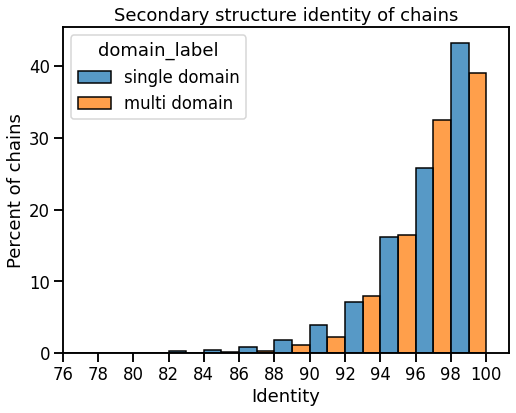

In [18]:
df = analyses_by_level['chain2chain']
df = df[df.analysis_name == 'CompareSecondaryStructure']
df = df.merge(a_h_pairs, left_on='args', right_on='args')
# přidat field single/multi domain
# todo mozna dat na single domain vsechny, kde nebyly nalezeny domeny?
#  - ne to je spis spatne, to muzou byt i velke proteiny..

df.loc[df['domain_count'] == 1, 'domain_label'] = 'single domain'
df.loc[df['domain_count'] > 1, 'domain_label'] = 'multi domain'

LOWER_DISPLAY_BOUND_ON_SS_IDENTITY = 0.76

outliers = df[df.result < LOWER_DISPLAY_BOUND_ON_SS_IDENTITY]
print(outliers)
print('outliers:', len(outliers))
print('all:', len(df))

def rounded_bins(a, binwidth):
    lower_bound = math.floor(np.min(a) / binwidth) * binwidth
    upper_bound = math.ceil(np.max(a) / binwidth) * binwidth

    return np.linspace(lower_bound, upper_bound, 1 + (int) ((upper_bound-lower_bound) / binwidth))

df['result_percent'] = df.result * 100
LOWER_DISPLAY_BOUND_ON_SS_IDENTITY *=100
BINWIDTH = 2
hue_order = ['single domain', 'multi domain']
ax = sns.histplot(df, x='result_percent', stat='percent', common_norm=False, hue='domain_label',
             hue_order=hue_order, multiple='dodge', bins=rounded_bins(df['result_percent'], BINWIDTH))
             # hue_order=hue_order, multiple='dodge', binwidth=BINWIDTH, binrange=(LOWER_DISPLAY_BOUND_ON_SS_IDENTITY, 1))  # gate out outliers (148)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=BINWIDTH))
ax.set(xlim=(LOWER_DISPLAY_BOUND_ON_SS_IDENTITY, None))
ax.set_title('Secondary structure identity of chains')
ax.set_xlabel('Identity')
ax.set_ylabel('Percent of chains')
save_plot()

/tmp/ipykernel_15494/914023157.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domain_df['apo_holo_chain'] = domain_df.args.apply(lambda domain_pair: (domain_pair[0][0:2], domain_pair[1][0:2]))


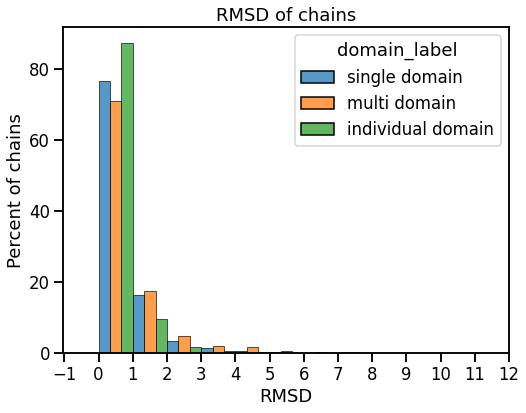

In [19]:
df = analyses_by_level['chain2chain']
df = df[df.analysis_name == 'GetRMSD']

df = df.merge(a_h_pairs, left_on='args', right_on='args')
# přidat field single/multi domain

df.loc[df['domain_count'] == 1, 'domain_label'] = 'single domain'
df.loc[df['domain_count'] > 1, 'domain_label'] = 'multi domain'


d2d_rmsd = analyses_by_level['domain2domain'].query('analysis_name == "GetRMSD"')
# for merging, extract in new column only a-h tuple of (pdb_code, chain_id) from the a-h tuple of triples with also a
# domain_id
domain_df = d2d_rmsd[:]
domain_df['apo_holo_chain'] = domain_df.args.apply(lambda domain_pair: (domain_pair[0][0:2], domain_pair[1][0:2]))
domain_df = domain_df.merge(df[df.domain_label == 'multi domain']['args'], left_on='apo_holo_chain', right_on='args')
domain_df['domain_label'] = 'individual domain'

df = pd.concat([df, domain_df], ignore_index=True)

BINWIDTH = 1
ax = sns.histplot(df, x='result', stat='percent', common_norm=False, hue='domain_label', multiple='dodge',
                  bins=rounded_bins(df['result'], BINWIDTH), hue_order=hue_order + ['individual domain'])
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=BINWIDTH))
ax.set(xlim=(None, 12))
ax.set_title('RMSD of chains')
ax.set_xlabel('RMSD')
ax.set_ylabel('Percent of chains')
save_plot()

## Domain motions
Two-domain arrangements

filter two-domain arrangements (if of both apo and holo > 200 A^2)

classified movements, 3 classes:
- shear (RMSD > 1 and < 2 Å)
- hinge (RMSD > 2 Å, bending > 10)
- other movement.

>We found that shear-type mechanism is
 the most frequent type of domain motion in the dataset
 (53%); hinge-bending is common for 45%, and the
 remaining cases cannot be unambiguously classified.

2DA bending [deg] vs RMSD (asi 2DA)

>the degree of
 bending (defined as the largest difference in the angle
 formed by the principal axis of individual domains)

We use screw axis angle (is generally smaller?)

In [20]:
# todo jeste odfiltrovat < 200 A^2

df = analyses_by_level['chain2DA2chain2DA']
two_domain_arrangements = df[df.analysis_name == 'GetRMSD']['args']
two_domain_arrangements = unfold_tuple_to_columns(two_domain_arrangements, ['apo_domains', 'holo_domains'])
print('two-domain arrangements count (present in apo and holo)', len(two_domain_arrangements))
# podivej se na ty domeny, (full spany) a lcs a spočítej přes min a max délku v lcs a celkovou
# pro obe domény? Ano, pro kazdy par 2DA. Merguj s make_lcs

# add pair_id column, needed later
def make_pair_id_column(apo_domains, holo_domains):
    apo2DA_unfolded = unfold_tuple_to_columns(apo_domains, ['d1', 'd2'])
    holo2DA_unfolded = unfold_tuple_to_columns(holo_domains, ['d1', 'd2'])

    apo2DA_unfolded = unfold_tuple_to_columns(apo2DA_unfolded['d1'], ['pdb_code', 'chain_id', 'domain_id'])
    holo2DA_unfolded = unfold_tuple_to_columns(holo2DA_unfolded['d1'], ['pdb_code', 'chain_id', 'domain_id'])

    pair_id = tuple_columns(
        tuple_columns(apo2DA_unfolded['pdb_code'], apo2DA_unfolded['chain_id']),
        tuple_columns(holo2DA_unfolded['pdb_code'], holo2DA_unfolded['chain_id']),
    )
    return pair_id

two_domain_arrangements['pair_id'] = make_pair_id_column(two_domain_arrangements['apo_domains'], two_domain_arrangements['holo_domains'])

# muzu zjisit pouze z full vs analyzed... Jinak bych si musel ukladat jeste label_seq_id start ve filter_structures
# nikoliv z full vs lcs
def compute_observed_ratio(analyzed_domain_spans, full_domain_spans):
    def get_length(spans):
        length = 0
        for start, end in spans:
            length += end - start + 1
        return length
    return get_length(analyzed_domain_spans) / get_length(full_domain_spans)


# celkem tam jsou 4 domény (2 v apu, 2 v holu). A chci, aby to platilo pro všechny 4.
# asi bych to nemergoval a dělal rovnou loc..

# create dataframe of cols which will be added to two_domain_arrangements
ratios = defaultdict(list)
for row in two_domain_arrangements.itertuples():
    ad1, ad2 = row.apo_domains
    hd1, hd2 = row.holo_domains

    # todo no idea why the following does not work? Raises KeyError: "None of [Index(['1tgb', 'A', '1tgbA01'], dtype='object', name='full_id')] are in the [index]"
    # full_spans = full_domains.loc[ad1, 'spans']
    full_spans_d1 = full_domains.at[ad1, 'spans']
    full_spans_d2 = full_domains.at[ad2, 'spans']

    for colname, full_spans, d in zip(('ad1', 'ad2', 'hd1', 'hd2'), (full_spans_d1, full_spans_d2, full_spans_d1, full_spans_d2), (ad1, ad2, hd1, hd2)):
        analyzed_spans = analyzed_domains.at[(d, row.pair_id), 'spans']
        ratios[colname].append(compute_observed_ratio(analyzed_spans, full_spans))

two_domain_arrangements = two_domain_arrangements.assign(**ratios)

two-domain arrangements count (present in apo and holo) 249534


Remove too short lcs (join with a_h_pairs, where only >=50 aa lcs are). Either way, those were probably already removed in the short domain removal.

Remove 2DAs that don't have meet the threshold for a observed residues in a domain:

In [21]:
df = two_domain_arrangements
# df = df[(df.ad1 > 0.5) & (df.ad2 > 0.5)]
OBSERVED_THRESHOLD = 0.5

# remove_data_with_short_domains
two_domain_arrangements = df[
    (df.ad1 > OBSERVED_THRESHOLD)
     & (df.ad2 > OBSERVED_THRESHOLD)
     & (df.hd1 > OBSERVED_THRESHOLD)
     & (df.hd2 > OBSERVED_THRESHOLD)
]
# and remove data with short lcs (already removed in a_h_pairs)
two_domain_arrangements = two_domain_arrangements[two_domain_arrangements.pair_id.isin(set(a_h_pairs['args']))]

print('valid two-domain arrangements count (present in apo and holo)', len(two_domain_arrangements))

allowed_2DA_ids = set(two_domain_arrangements.args)

filtered_results = []
for row in analyses_by_level['chain2DA2chain2DA'].itertuples(index=False):
    # I unfortunately wasn't strict in that each level tag has same args..
    if row.analysis_name == 'GetRMSD':
        _2DA_id = row.args
    else:
        _2DA_id = row.args[:2], row.args[2:]

    if _2DA_id in allowed_2DA_ids:
        filtered_results.append(row._asdict())

old_chain2DA2chain2DA = analyses_by_level['chain2DA2chain2DA']
analyses_by_level['chain2DA2chain2DA'] = pd.DataFrame.from_records(filtered_results)


# print(len(two_domain_arrangements2))
# df[~((df.ad1 > OBSERVED_THRESHOLD)
#      & (df.ad2 > OBSERVED_THRESHOLD)
#      & (df.hd1 > OBSERVED_THRESHOLD)
#      & (df.hd2 > OBSERVED_THRESHOLD))]

valid two-domain arrangements count (present in apo and holo) 3019


3019
3019
3019


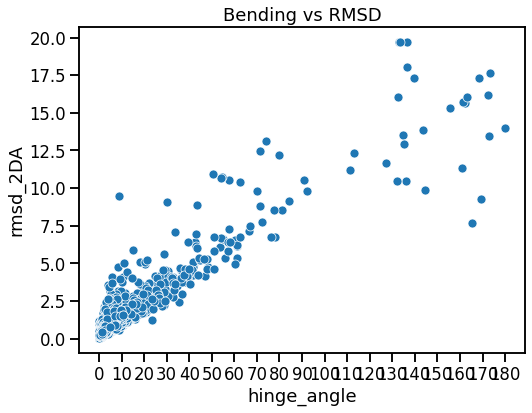

In [22]:
df = analyses_by_level['chain2DA2chain2DA']
rmsd_df = df[df.analysis_name == 'GetRMSD'].rename(columns={'result': 'rmsd_2DA'})
hinge_df = df[df.analysis_name == 'GetHingeAngle']


# actually `result` is a dict, with meaningful names angle, translation_in_axis, translation_overall
hinge_df = unfold_tuple_to_columns(hinge_df, column_name='result').rename(columns={'angle': 'hinge_angle'})

# convert args, so that format is the same - rmsd has ((a_d1, a_d2), (h_d1, h_d2))
# while hinge had (a_d1, a_d2, h_d1, h_d2)
hinge_df['args'] = hinge_df['args'].apply(lambda t: ((t[0], t[1]), (t[2], t[3])))
hinge_df['hinge_angle'] = 360/(2*np.pi) * hinge_df['hinge_angle']

hinge_df = unfold_tuple_to_columns(hinge_df, ['apo_domains', 'holo_domains'], 'args')
hinge_df['pair_id'] = make_pair_id_column(hinge_df['apo_domains'], hinge_df['holo_domains'])

print(len(hinge_df))
print(len(rmsd_df))
rmsd_and_hinge = rmsd_df.merge(hinge_df, on='args')

print(len(rmsd_and_hinge))
ax = sns.scatterplot(data=rmsd_and_hinge, x='hinge_angle', y='rmsd_2DA')
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=10))
ax.set_title('Bending vs RMSD')
save_plot()
# zobrazit si ty, co tvrděj, že jsou shear a podívat se, jestli opravdu jde o shear -> mají ~~translation_in_axis~~ translation_overall, třeba
# větší než hinge'
# podle mě částs může být shear, ale i to může být akomodace ligandu jednou doménou, kdy druhá zůstane nezměněná
#   to zjistim poměrem rmsd jedné a druhé domény plot_vs translation_in_axis
    # min{rmsd_d1/rmsd_d2 a d2/d1}
    # pak můžu ještě si je zobrazit na interfacu. Protoze shear by preci se mel menit interface. Nemusi, kdyz jedna domena je treba mensi..



14:56 jsem odstranil ty páry, co neměly žádný dobrý domény, ale nikoliv podle přímo těch domén, to až teď

## Shear, as classified in the paper
- classified as RMSD value between 1 and 2 (RMSD of apo and holo two-domain arrangements)
- or rather it incorrectly includes cases, where only one domain accommodates the ligand

In [34]:
print(len(rmsd_and_hinge))
print(len(d2d_rmsd))

3019
995482


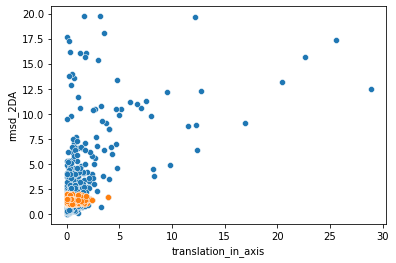

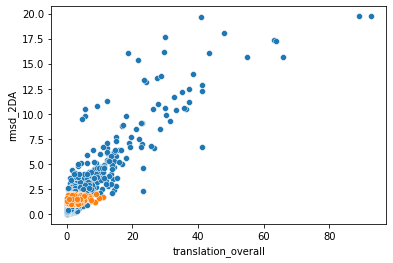

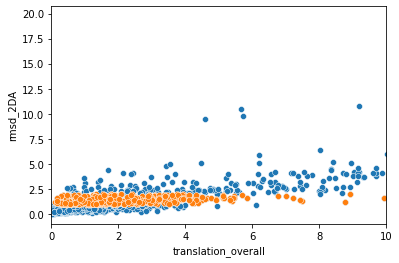

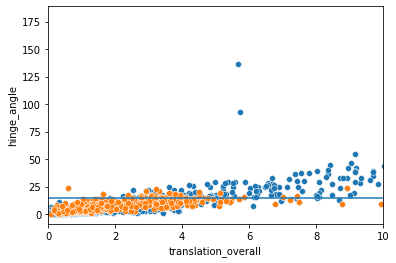

,hinge_angle,translation_overall,translation_in_axis,rmsd_2DA,domain_rmsd_x,domain_rmsd_y
1487,0.115350,0.097220,0.079157,1.17712,0.098124,1.295446
2923,5.186707,0.164424,0.119843,1.66138,0.395110,2.087833
2973,3.519364,0.164514,0.002387,1.279327,0.830451,1.685406
557,2.581643,0.165451,0.080627,1.281422,1.379645,0.197514
1499,2.592840,0.166126,0.150640,1.330382,1.676614,0.401054
...,...,...,...,...,...,...
2171,11.070426,7.482034,1.724919,1.324839,0.817122,0.846268
2418,9.221002,8.775551,1.398088,1.178629,0.620441,0.301801
2905,23.840690,8.923033,0.074216,1.993601,0.573358,1.324105
2701,9.549255,9.926407,1.700880,1.614193,0.353644,0.615737


In [35]:
df = rmsd_and_hinge[:]
df = unfold_tuple_to_columns(df, ['apo_domains', 'holo_domains'], 'args')
df = unfold_tuple_to_columns(df, ['apo_domain_1', 'apo_domain_2'], 'apo_domains')
df = unfold_tuple_to_columns(df, ['holo_domain_1', 'holo_domain_2'], 'holo_domains')
# convert args, so that format is the same - as single domain rmsd
df['d1_id'] = tuple_columns(df.apo_domain_1, df.holo_domain_1)
df['d2_id'] = tuple_columns(df.apo_domain_2, df.holo_domain_2)
d2d_rmsd_selected_cols = d2d_rmsd[['args', 'result']].rename(columns={'args': 'rmsd_domain_id', 'result': 'domain_rmsd'})
df = df.merge(d2d_rmsd_selected_cols, left_on='d1_id', right_on='rmsd_domain_id')
df = df.merge(d2d_rmsd_selected_cols, left_on='d2_id', right_on='rmsd_domain_id')

all = df[:]
paper_shear = df[(1 < df.rmsd_2DA) & (df.rmsd_2DA < 2)]  # gather shears

# rmsd_2DA vs translation_in_axis
ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_in_axis', y='rmsd_2DA')
ax = sns.scatterplot(data=paper_shear, x='translation_in_axis', y='rmsd_2DA')
plt.show()


# rmsd_2DA vs translation_overall
ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_overall', y='rmsd_2DA')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='rmsd_2DA')
plt.show()

# rmsd_2DA vs translation_overall
ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_overall', y='rmsd_2DA')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='rmsd_2DA')
ax.set(xlim=(0, 10))
plt.show()


ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_overall', y='hinge_angle')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='hinge_angle')
ax.set(xlim=(0, 10))
ax.axhline(15)
plt.show()

paper_shear[['hinge_angle',  'translation_overall','translation_in_axis', 'rmsd_2DA', 'domain_rmsd_x', 'domain_rmsd_y']].sort_values(by='translation_overall')

# all = all[all.rmsd_2DA > 1]
# all[['hinge_angle',  'translation_overall','translation_in_axis', 'rmsd_2DA', 'domain_rmsd_x', 'domain_rmsd_y']].sort_values(by='translation_overall')


In [48]:
paper_shear.sort_values(by='translation_overall')

,Index_x,analysis_name_x,args,kwargs_x,rmsd_2DA,level_tag_x,Index_y,analysis_name_y,kwargs_y,result,...,apo_domain_1,apo_domain_2,holo_domain_1,holo_domain_2,d1_id,d2_id,rmsd_domain_id_x,domain_rmsd_x,rmsd_domain_id_y,domain_rmsd_y
1487,13993,GetRMSD,"(((1v7v, A, 1v7vA02), (1v7v, A, 1v7vA03)), ((1...",{},1.17712,chain2DA2chain2DA,13992,GetHingeAngle,{},"{'angle': 0.002013235508753, 'translation_in_a...",...,"(1v7v, A, 1v7vA02)","(1v7v, A, 1v7vA03)","(1v7x, A, 1v7vA02)","(1v7x, A, 1v7vA03)","((1v7v, A, 1v7vA02), (1v7x, A, 1v7vA02))","((1v7v, A, 1v7vA03), (1v7x, A, 1v7vA03))","((1v7v, A, 1v7vA02), (1v7x, A, 1v7vA02))",0.098124,"((1v7v, A, 1v7vA03), (1v7x, A, 1v7vA03))",1.295446
2923,10015,GetRMSD,"(((4b5z, A, 4b5zA01), (4b5z, A, 4b5zA02)), ((4...",{},1.66138,chain2DA2chain2DA,10014,GetHingeAngle,{},"{'angle': 0.09052511281443201, 'translation_in...",...,"(4b5z, A, 4b5zA01)","(4b5z, A, 4b5zA02)","(4b60, A, 4b5zA01)","(4b60, A, 4b5zA02)","((4b5z, A, 4b5zA01), (4b60, A, 4b5zA01))","((4b5z, A, 4b5zA02), (4b60, A, 4b5zA02))","((4b5z, A, 4b5zA01), (4b60, A, 4b5zA01))",0.395110,"((4b5z, A, 4b5zA02), (4b60, A, 4b5zA02))",2.087833
2973,9250,GetRMSD,"(((1f1z, B, 1f1zB01), (1f1z, B, 1f1zB02)), ((1...",{},1.279327,chain2DA2chain2DA,9248,GetHingeAngle,{},"{'angle': 0.061424490605898004, 'translation_i...",...,"(1f1z, B, 1f1zB01)","(1f1z, B, 1f1zB02)","(1t0f, A, 1f1zB01)","(1t0f, A, 1f1zB02)","((1f1z, B, 1f1zB01), (1t0f, A, 1f1zB01))","((1f1z, B, 1f1zB02), (1t0f, A, 1f1zB02))","((1f1z, B, 1f1zB01), (1t0f, A, 1f1zB01))",0.830451,"((1f1z, B, 1f1zB02), (1t0f, A, 1f1zB02))",1.685406
557,10587,GetRMSD,"(((3e04, B, 3e04B02), (3e04, B, 3e04B03)), ((5...",{},1.281422,chain2DA2chain2DA,10586,GetHingeAngle,{},"{'angle': 0.04505817626702, 'translation_in_ax...",...,"(3e04, B, 3e04B02)","(3e04, B, 3e04B03)","(5upp, B, 3e04B02)","(5upp, B, 3e04B03)","((3e04, B, 3e04B02), (5upp, B, 3e04B02))","((3e04, B, 3e04B03), (5upp, B, 3e04B03))","((3e04, B, 3e04B02), (5upp, B, 3e04B02))",1.379645,"((3e04, B, 3e04B03), (5upp, B, 3e04B03))",0.197514
1499,368,GetRMSD,"(((3la7, B, 3la7B01), (3la7, B, 3la7B02)), ((3...",{},1.330382,chain2DA2chain2DA,367,GetHingeAngle,{},"{'angle': 0.045253598980063, 'translation_in_a...",...,"(3la7, B, 3la7B01)","(3la7, B, 3la7B02)","(3la7, A, 3la7B01)","(3la7, A, 3la7B02)","((3la7, B, 3la7B01), (3la7, A, 3la7B01))","((3la7, B, 3la7B02), (3la7, A, 3la7B02))","((3la7, B, 3la7B01), (3la7, A, 3la7B01))",1.676614,"((3la7, B, 3la7B02), (3la7, A, 3la7B02))",0.401054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171,5375,GetRMSD,"(((3c0n, A, 3c0nA01), (3c0n, A, 3c0nA03)), ((3...",{},1.324839,chain2DA2chain2DA,5374,GetHingeAngle,{},"{'angle': 0.19321538004087802, 'translation_in...",...,"(3c0n, A, 3c0nA01)","(3c0n, A, 3c0nA03)","(3c0o, B, 3c0nA01)","(3c0o, B, 3c0nA03)","((3c0n, A, 3c0nA01), (3c0o, B, 3c0nA01))","((3c0n, A, 3c0nA03), (3c0o, B, 3c0nA03))","((3c0n, A, 3c0nA01), (3c0o, B, 3c0nA01))",0.817122,"((3c0n, A, 3c0nA03), (3c0o, B, 3c0nA03))",0.846268
2418,9502,GetRMSD,"(((4zpm, B, 4zpmB01), (4zpm, B, 4zpmB03)), ((4...",{},1.178629,chain2DA2chain2DA,9501,GetHingeAngle,{},"{'angle': 0.16093684434289302, 'translation_in...",...,"(4zpm, B, 4zpmB01)","(4zpm, B, 4zpmB03)","(4zpm, A, 4zpmB01)","(4zpm, A, 4zpmB03)","((4zpm, B, 4zpmB01), (4zpm, A, 4zpmB01))","((4zpm, B, 4zpmB03), (4zpm, A, 4zpmB03))","((4zpm, B, 4zpmB01), (4zpm, A, 4zpmB01))",0.620441,"((4zpm, B, 4zpmB03), (4zpm, A, 4zpmB03))",0.301801
2905,8062,GetRMSD,"(((1ng2, A, 1ng2A01), (1ng2, A, 1ng2A02)), ((1...",{},1.993601,chain2DA2chain2DA,8061,GetHingeAngle,{},"{'angle': 0.416098531534962, 'translation_in_a...",...,"(1ng2, A, 1ng2A01)","(1ng2, A, 1ng2A02)","(1ov3, A, 1ng2A01)","(1ov3, A, 1ng2A02)","((1ng2, A, 1ng2A01), (1ov3, A, 1ng2A01))","((1ng2, A, 1ng2A02), (1ov3, A, 1ng2A02))","((1ng2, A, 1ng2A01), (1ov3, A, 1ng2A01))",0.573358,"((1ng2, A, 1ng2A02), (1ov3, A, 1ng2A02))",1.324105
2701,6078,GetRMSD,"(((5knl, A, 5knlA03), (5knl, A, 5knlA06)), (

In [36]:
# jak to, ze maji rmsd 1-2 a pritom tak velky hinge?
# Mozna se podivat na analyzed domain definition
# ano - treba 3kqg, 3p5d, holo struktura je kratsi a ma jenom jednu domenu, ale premapovani ty druhy apo
# zpusobi, ze bude mit treba jenom 2 residua, ktery se zrovna moc nehybou...
# Rekl bych, ze tyhle pripady (krome thresholdu na pomer zbyly residui v domene) by se odfiltrovaly
# i tim 200 A^2 thresholdem na interface
paper_shear[paper_shear.hinge_angle > 75]


,Index_x,analysis_name_x,args,kwargs_x,rmsd_2DA,level_tag_x,Index_y,analysis_name_y,kwargs_y,result,...,apo_domain_1,apo_domain_2,holo_domain_1,holo_domain_2,d1_id,d2_id,rmsd_domain_id_x,domain_rmsd_x,rmsd_domain_id_y,domain_rmsd_y


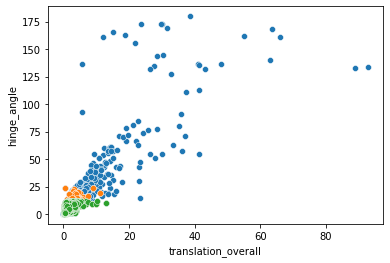

In [37]:
ax = sns.scatterplot(data=rmsd_and_hinge, x='translation_overall', y='hinge_angle')
ax = sns.scatterplot(data=paper_shear, x='translation_overall', y='hinge_angle')
ax = sns.scatterplot(data=rmsd_and_hinge[
    (rmsd_and_hinge.translation_overall > 0.2) & (rmsd_and_hinge.hinge_angle < 12)], x='translation_overall', y='hinge_angle')


/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/venv/lib/python3.8/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'args_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


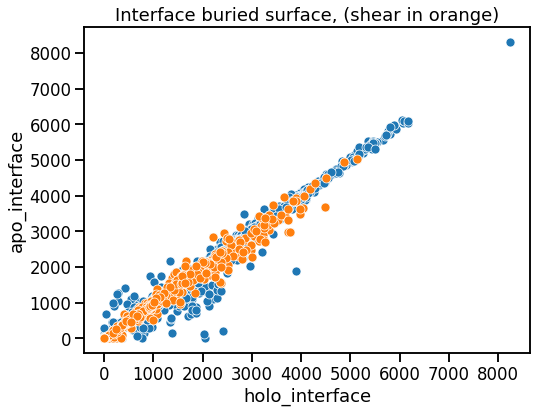

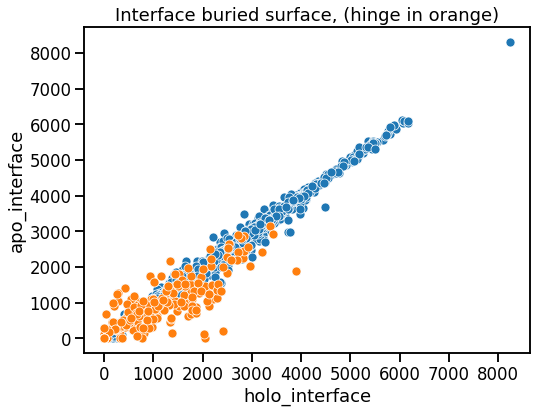

In [23]:
df = analyses_by_level['2DA']

interface_area = df[df.analysis_name == 'GetInterfaceBuriedArea']
df = unfold_tuple_to_columns(interface_area, ['d1', 'd2', 'pair_id'], 'args')
interface_area['2DA_id'] = tuple_columns(df.d1, df.d2)
interface_area['pair_id'] = df['pair_id']
interface_area = interface_area.set_index(['2DA_id', 'pair_id'])

df = two_domain_arrangements.merge(interface_area, left_on=['apo_domains', 'pair_id'], right_index=True)
df = df.rename(columns={'result': 'apo_interface'})
df = df.merge(interface_area, left_on=['holo_domains', 'pair_id'], right_index=True)
df = df.rename(columns={'result': 'holo_interface'})

interface_area_apo_holo = df

def show_all():
    ax = sns.scatterplot(data=df, x='holo_interface', y='apo_interface')
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1000))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1000))

df = df.merge(hinge_df, left_on=['apo_domains', 'pair_id'], right_on=['apo_domains', 'pair_id'])

def show_shear():
    sns.scatterplot(data=df[(df.translation_overall > 1) & (df.hinge_angle < 15)], x='holo_interface', y='apo_interface')

def show_hinge():
    sns.scatterplot(data=df[(df.hinge_angle > 15)], x='holo_interface', y='apo_interface')

show_all()
show_shear()
plt.title('Interface buried surface, (shear in orange)')
save_plot()
plt.show()


show_all()
show_hinge()
plt.title('Interface buried surface, (hinge in orange)')
save_plot()
plt.show()
# todo udělat diagonálu

# df[df.apo_interface > 6000]
# 8300 outlier = large beta barrel 1pnz, 1kmo


Compared to the paper, it's estimated as larger.

2DA
prediktor large-scale motion type z apo interface buried

interface buried (apo) vs (bending)|(RMSD - opět 2DA-explicitně)
- scatter and histogram


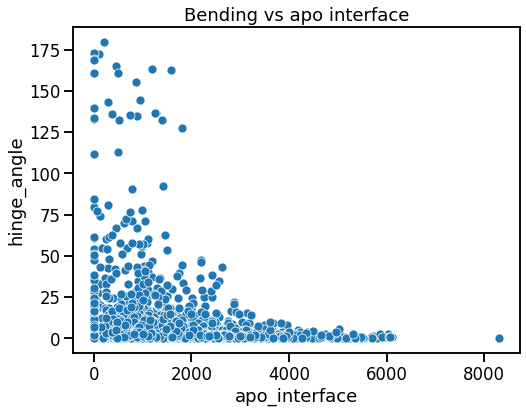

In [24]:
df = hinge_df
df = df.merge(interface_area, left_on=['apo_domains', 'pair_id'], right_on=['2DA_id', 'pair_id'])
df = df.rename(columns={'result_y': 'apo_interface'})

# to nefunguje, kdyz to neni v tom contextu, tak to nic nedělá
# sns.set_context("notebook", rc={"scatter.marker": ','})
#
# import matplotlib as mpl
# # mpl.rcdefaults()
# mpl.rc('scatter', marker='o')
# mpl.rc('lines', markersize=2)
# mpl.rc('figure', figsize=[12, 8])

# sns.set_theme()
ax = sns.scatterplot(data=df, x='apo_interface', y='hinge_angle')
ax.set_title('Bending vs apo interface')
save_plot()
# true shear dataset
# sns.scatterplot(data=df[(df.translation_overall > 1) & (df.hinge_angle < 12)], x='apo_interface', y='hinge_angle')
# mpl.rcdefaults()
# sns.set_context()

plt.rcParams['figure.figsize'] = [12, 8]We can see that domain interface area (in apo structure) indeed sets a limit on whether the domains can do a hinge motion. Hinge bending domain pairs with interface area larger than 2000 Å^2 were not observed.

The conclusion for shear, in the paper, holds too.
No lg scale dom. movements above 3550 A2 interface.

deducible by the
examination of a ligand-free structural form alone.
- mění se něco? Může to být víc deducible ještě z něčeho novýho, co máme ted k dispozici? Asi ne..

Zkusil bych ještě |holo_interface-apo_interface|/apo_interface vs hinge angle
Ale to, že to nedělá 90° protože by zmizel interface je moc noisy závěr. Možná pro 'nejtěžší' principal axis by to šlo říct.

,Index_x,analysis_name_x,args_x,kwargs_x,result_x,level_tag_x,hinge_angle,translation_in_axis,translation_overall,apo_domains,...,kwargs_y,apo_interface,level_tag_y,Index,analysis_name,args,kwargs,holo_interface,level_tag,interface_change_ratio
1389,187,GetHingeAngle,"(((1k04, A, 1k04A01), (1k04, A, 1k04A02)), ((1...",{},"{'angle': 3.139506714797233, 'translation_in_a...",chain2DA2chain2DA,179.880485,0.463505,38.625759,"((1k04, A, 1k04A01), (1k04, A, 1k04A02))",...,{},203.978522,2DA,179,GetInterfaceBuriedArea,"((1ow6, C, 1k04A01), (1ow6, C, 1k04A02), ((1k0...",{},2404.085989,2DA,10.785976
1912,2224,GetHingeAngle,"(((6nci, A, 6nciA01), (6nci, A, 6nciA02)), ((6...",{},"{'angle': 2.835077595212981, 'translation_in_a...",chain2DA2chain2DA,162.437981,22.610587,55.064812,"((6nci, A, 6nciA01), (6nci, A, 6nciA02))",...,{},1581.651249,2DA,2219,GetInterfaceBuriedArea,"((6nci, B, 6nciA01), (6nci, B, 6nciA02), ((6nc...",{},1015.905098,2DA,-0.357693
1925,11825,GetHingeAngle,"(((2nxc, A, 2nxcA01), (2nxc, A, 2nxcA02)), ((3...",{},"{'angle': 2.887400591128999, 'translation_in_a...",chain2DA2chain2DA,165.435868,2.827176,15.033112,"((2nxc, A, 2nxcA01), (2nxc, A, 2nxcA02))",...,{},455.473748,2DA,11809,GetInterfaceBuriedArea,"((3egv, A, 2nxcA01), (3egv, A, 2nxcA02), ((2nx...",{},176.877455,2DA,-0.611663
2013,1225,GetHingeAngle,"(((1ygy, A, 1ygyA01), (1ygy, A, 1ygyA03)), ((1...",{},"{'angle': 2.717156769467234, 'translation_in_a...",chain2DA2chain2DA,155.681615,2.930236,21.687107,"((1ygy, A, 1ygyA01), (1ygy, A, 1ygyA03))",...,{},867.161429,2DA,1197,GetInterfaceBuriedArea,"((1ygy, B, 1ygyA01), (1ygy, B, 1ygyA03), ((1yg...",{},607.589565,2DA,-0.299335
2015,1229,GetHingeAngle,"(((1ygy, A, 1ygyA02), (1ygy, A, 1ygyA03)), ((1...",{},"{'angle': 2.84591365746873, 'translation_in_ax...",chain2DA2chain2DA,163.058841,1.274536,18.665010,"((1ygy, A, 1ygyA02), (1ygy, A, 1ygyA03))",...,{},1194.463730,2DA,1206,GetInterfaceBuriedArea,"((1ygy, B, 1ygyA02), (1ygy, B, 1ygyA03), ((1yg...",{},606.648320,2DA,-0.492117
2760,7621,GetHingeAngle,"(((3fwe, B, 3fweB01), (3fwe, B, 3fweB02)), ((3...",{},"{'angle': 2.808321026484222, 'translation_in_a...",chain2DA2chain2DA,160.904942,7.516496,12.198724,"((3fwe, B, 3fweB01), (3fwe, B, 3fweB02))",...,{},508.098335,2DA,7616,GetInterfaceBuriedArea,"((3kcc, B, 3fweB01), (3kcc, B, 3fweB02), ((3fw...",{},865.304251,2DA,0.703025


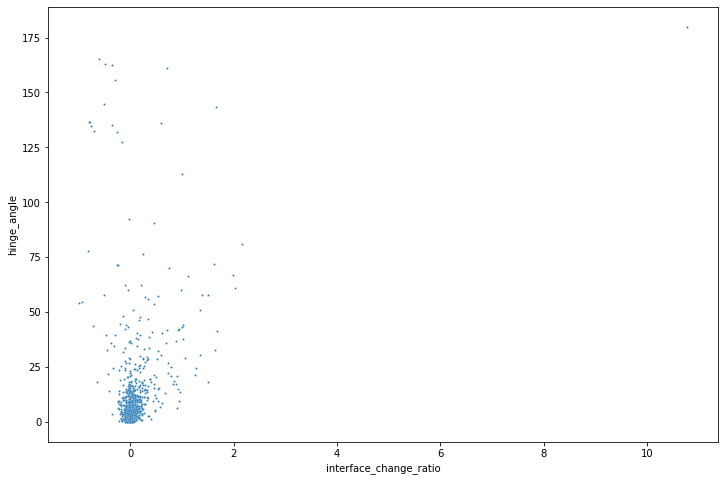

In [47]:
df = hinge_df
df = df.merge(interface_area, left_on=['apo_domains', 'pair_id'], right_on=['2DA_id', 'pair_id'])
df = df.rename(columns={'result_y': 'apo_interface'})
df = df.merge(interface_area, left_on=['holo_domains', 'pair_id'], right_on=['2DA_id', 'pair_id'])
df = df.rename(columns={'result': 'holo_interface'})

df['interface_change_ratio'] = (df['holo_interface'] - df['apo_interface']) / df['apo_interface']
df = df[df['apo_interface'] >= 200]
sns.scatterplot(data=df, x='interface_change_ratio', y='hinge_angle')
df[df.hinge_angle > 150]


3019
3019


<AxesSubplot:xlabel='apo_interface', ylabel='rmsd_2DA'>

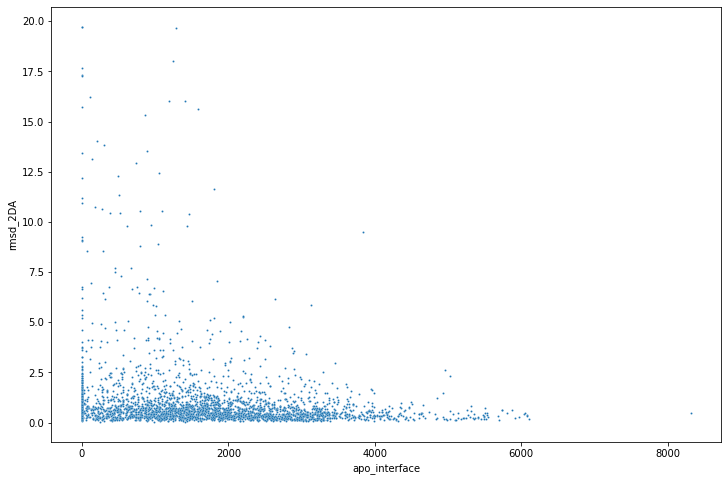

In [41]:
df = rmsd_df
df = unfold_tuple_to_columns(df, ['apo_domains', 'holo_domains'], 'args')
df['pair_id'] = make_pair_id_column(df['apo_domains'], df['holo_domains'])

print(len(df))
df = df.merge(interface_area.rename(columns={'result': 'apo_interface'}), left_on=['apo_domains', 'pair_id'], right_on=['2DA_id', 'pair_id'])
print(len(df))
sns.scatterplot(data=df, x='apo_interface', y='rmsd_2DA')



---
### Just debugging memory usage

## Domain motions
Two-domain arrangements

filter two-domain arrangements (if of both apo and holo > 200 A^2)

classified movements, 3 classes:
- shear (RMSD > 1 and < 2 Å)
- hinge (RMSD > 2 Å, bending > 10)
- other movement.

>We found that shear-type mechanism is
 the most frequent type of domain motion in the dataset
 (53%); hinge-bending is common for 45%, and the
 remaining cases cannot be unambiguously classified.

2DA bending [deg] vs RMSD (asi 2DA)

>the degree of
 bending (defined as the largest difference in the angle
 formed by the principal axis of individual domains)

We use screw axis angle (is generally smaller?)

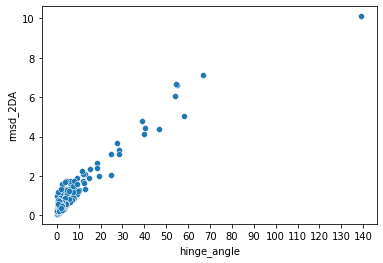

In [9]:
# todo jeste odfiltrovat < 200 A^2

df = analyses_dfs['chain2DA2chain2DA']
rmsd_df = df[df.analysis_name == 'GetRMSD'].rename(columns={'result': 'rmsd_2DA'})
hinge_df = df[df.analysis_name == 'GetHingeAngle']

# actually `result` is a dict, with meaningful names angle, translation_in_axis, translation_overall
hinge_df = unfold_tuple_to_columns(hinge_df, column_name='result').rename(columns={'angle': 'hinge_angle'})

# convert args, so that format is the same - rmsd has ((a_d1, a_d2), (h_d1, h_d2))
# while hinge had (a_d1, a_d2, h_d1, h_d2)
hinge_df['args'] = hinge_df['args'].apply(lambda t: ((t[0], t[1]), (t[2], t[3])))
hinge_df['hinge_angle'] = 360/(2*np.pi) * hinge_df['hinge_angle']

rmsd_and_hinge = rmsd_df.merge(hinge_df, left_on='args', right_on='args')

ax = sns.scatterplot(data=rmsd_and_hinge, x='hinge_angle', y='rmsd_2DA')
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=10))

# zobrazit si ty, co tvrděj, že jsou shear a podívat se, jestli opravdu jde o shear -> mají translation_in_axis, třeba
# větší než hinge
# podle částs může být shear, ale i to může být akomodace ligandu jednou doménou, kdy druhá zůstane nezměněná
#   to zjistim poměrem rmsd jedné a druhé domény plot_vs translation_in_axis
    # min{rmsd_d1/rmsd_d2 a d2/d1}
    # pak můžu ještě si je zobrazit na interfacu. Protoze shear by preci se mel menit interface. Mozna, ze ta moje
# druha kategorie bude krásně na diagonále true shear bude od ní. Kdoví. Ale taky se nemusí měnit iface v některých
# konfiguracích, i když dojde k translation



2DA bending [deg] vs RMSD (asi 2DA)

>the degree of
 bending (defined as the largest difference in the angle
 formed by the principal axis of individual domains)

We use screw axis angle (is generally smaller?)

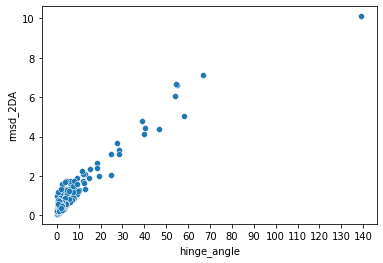

In [9]:
# todo jeste odfiltrovat < 200 A^2

df = analyses_dfs['chain2DA2chain2DA']
rmsd_df = df[df.analysis_name == 'GetRMSD'].rename(columns={'result': 'rmsd_2DA'})
hinge_df = df[df.analysis_name == 'GetHingeAngle']

# actually `result` is a dict, with meaningful names angle, translation_in_axis, translation_overall
hinge_df = unfold_tuple_to_columns(hinge_df, column_name='result').rename(columns={'angle': 'hinge_angle'})

# convert args, so that format is the same - rmsd has ((a_d1, a_d2), (h_d1, h_d2))
# while hinge had (a_d1, a_d2, h_d1, h_d2)
hinge_df['args'] = hinge_df['args'].apply(lambda t: ((t[0], t[1]), (t[2], t[3])))
hinge_df['hinge_angle'] = 360/(2*np.pi) * hinge_df['hinge_angle']

rmsd_and_hinge = rmsd_df.merge(hinge_df, left_on='args', right_on='args')

ax = sns.scatterplot(data=rmsd_and_hinge, x='hinge_angle', y='rmsd_2DA')
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=10))

# zobrazit si ty, co tvrděj, že jsou shear a podívat se, jestli opravdu jde o shear -> mají translation_in_axis, třeba
# větší než hinge
# podle částs může být shear, ale i to může být akomodace ligandu jednou doménou, kdy druhá zůstane nezměněná
#   to zjistim poměrem rmsd jedné a druhé domény plot_vs translation_in_axis
    # min{rmsd_d1/rmsd_d2 a d2/d1}
    # pak můžu ještě si je zobrazit na interfacu. Protoze shear by preci se mel menit interface. Mozna, ze ta moje
# druha kategorie bude krásně na diagonále true shear bude od ní. Kdoví. Ale taky se nemusí měnit iface v některých
# konfiguracích, i když dojde k translation



2DA bending [deg] vs RMSD (asi 2DA)

>the degree of
 bending (defined as the largest difference in the angle
 formed by the principal axis of individual domains)

We use screw axis angle (is generally smaller?)

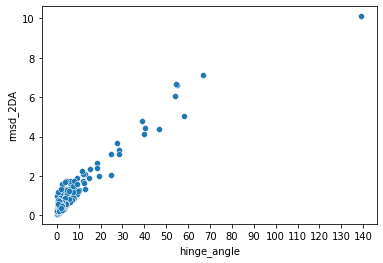

In [9]:
# todo jeste odfiltrovat < 200 A^2

df = analyses_dfs['chain2DA2chain2DA']
rmsd_df = df[df.analysis_name == 'GetRMSD'].rename(columns={'result': 'rmsd_2DA'})
hinge_df = df[df.analysis_name == 'GetHingeAngle']

# actually `result` is a dict, with meaningful names angle, translation_in_axis, translation_overall
hinge_df = unfold_tuple_to_columns(hinge_df, column_name='result').rename(columns={'angle': 'hinge_angle'})

# convert args, so that format is the same - rmsd has ((a_d1, a_d2), (h_d1, h_d2))
# while hinge had (a_d1, a_d2, h_d1, h_d2)
hinge_df['args'] = hinge_df['args'].apply(lambda t: ((t[0], t[1]), (t[2], t[3])))
hinge_df['hinge_angle'] = 360/(2*np.pi) * hinge_df['hinge_angle']

rmsd_and_hinge = rmsd_df.merge(hinge_df, left_on='args', right_on='args')

ax = sns.scatterplot(data=rmsd_and_hinge, x='hinge_angle', y='rmsd_2DA')
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=10))

# zobrazit si ty, co tvrděj, že jsou shear a podívat se, jestli opravdu jde o shear -> mají translation_in_axis, třeba
# větší než hinge
# podle částs může být shear, ale i to může být akomodace ligandu jednou doménou, kdy druhá zůstane nezměněná
#   to zjistim poměrem rmsd jedné a druhé domény plot_vs translation_in_axis
    # min{rmsd_d1/rmsd_d2 a d2/d1}
    # pak můžu ještě si je zobrazit na interfacu. Protoze shear by preci se mel menit interface. Mozna, ze ta moje
# druha kategorie bude krásně na diagonále true shear bude od ní. Kdoví. Ale taky se nemusí měnit iface v některých
# konfiguracích, i když dojde k translation



In [21]:
potential_pairs.memory_usage()
# 120 MB plus data (strings and lcs_results), how can that be 4 GB? When the json is 600 MB...
# string 53 bytes ~ 50 bytes (empty 49)
# lcs result 6 ints -> 48 bytes -> 3M * 0.1 kB = 0.3 GB, 40 bytes empty tuple
#     88 bytes if tuple
# but it's a dict! with non-interned strings :(((( wtf..

Index                                  128
pdb_code_apo                      23785904
chain_id_apo                      23785904
pdb_code_holo                     23785904
chain_id_holo                     23785904
lcs_result.length                 23785904
lcs_result.i1                     23785904
lcs_result.i2                     23785904
lcs_result.mismatches             23785904
lcs_result.leading_mismatches     23785904
lcs_result.trailing_mismatches    23785904
dtype: int64

In [22]:
# print(potential_pairs.describe())
pairs = potential_pairs[potential_pairs.mismatches == 0]
print(len(pairs))
pairs.describe()

AttributeError: 'DataFrame' object has no attribute 'mismatches'

In [ ]:
import gc
gc.collect()

In [ ]:
potential_pairs.columns


In [ ]:
df = pd.json_normalize('/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_make_pairs_lcs')

In [ ]:
from collections import defaultdict

json_filename = '/home/adam/pschool/bakalarka/apo-holo-protein-structure-stats/o_make_pairs_lcs'
with open(json_filename) as f:
    # items = []
    #
    # def intern_dict_keys(obj):
    #     interned_keys_obj = {}
    #     for k, v in obj.items():
    #         # k = sys.intern(k)
    #         interned_keys_obj[k] = v
    #
    #     global items
    #     items.append(interned_keys_obj)
    #     if len(items) == 10:
    #         items_by_len = defaultdict(list)
    #         for i in items:
    #             items_by_len[len(i)].append(i)
    #
    #         print(list(items_by_len.keys()))
    #         for items in items_by_len.values():
    #             for corr_keys in zip(*items):
    #                 for i in range(len(corr_keys)-1):
    #                     print(corr_keys[i] is corr_keys[i+1])
    #
    #     return interned_keys_obj
    # careful not to keep reference to loaded json
    potential_pairs = pd.json_normalize(json.load(f))


In [ ]:
print(potential_pairs.memory_usage())


In [ ]:
gc.collect()


In [ ]:
import gc
potential_pairs = potential_pairs.drop(columns='chain_id_holo')
potential_pairs = potential_pairs.drop(columns='chain_id_apo')


In [ ]:
print(potential_pairs.memory_usage())

In [ ]:
potential_pairs= []
gc.collect()
